<img src="../figures/Floodpy_logo.png" align='right' width='7%'/>

**Authors:**  Kleanthis Karamvasis, Pavlos Alexantonakis <br>
**Copyright:** 2021-2023 Kleanthis Karamvasis, Alekos Falagas <br>
**License:** GPLv3

<div class="alert alert-block alert-success">
<h3>Flood Mapping Using FLOODPY: Issue #35</h3></div>

### Learning outcomes

At the end of this notebook you will be able to identify flooded regions from Sentinel-1 data using FloodPy. Be aware that the estimated run time of the notebook depends on your **area of interest**, your **time of interest** and your network **download speed**. Using default settings the run time of the notebook is ~ 15 min

### Outline
<font size="3">
Floods are considered the second gravest disaster for the agricultural sector. The increasing intensity and the frequency of flood events can result to significant yield losses. In the present notebook we present a methodological pipeline (FLOODPY) to extract flooded area based on change detection approach using multitemporal Sentinel-1 intensity observations and precipitation data (ERA5 model). More info can be found at [1].
<br>
    
The FLOODPY - <b>FLOOD PYthon toolbox</b> is a free and open-source python toolbox for mapping of floodwater. FLOODPY requires a specified time of interest related to the flood event and corresponding geographical boundaries. We believe that the produced maps with delineated flood-affected agricultural fields can be helpful for governments, insurers and disaster response agencies to improve flood risk assessment, relief targeting, and ultimately to protect climate-vulnerable communities from floods. 

References:

<font size="1">
    
[1] Karamvasis K, Karathanassi V. FLOMPY: An Open-Source Toolbox for Floodwater Mapping Using Sentinel-1 Intensity Time Series. Water. 2021; 13(21):2943. [link](https://doi.org/10.3390/w13212943)


<div class="alert alert-info" role="alert">
    
## <a id='TOC_TOP'></a>Contents

</div>
    
[1. Flood event description](#section1)

[2. Set input arguments for FLOODPY](#section2)

[3. Estimation of Flooded Area](#section3)

[4. Interactive Plotting](#section4)

<hr>

<font size="3">
In this notebook we demonstrate the use of Sentinel-1, digital elevation model (SRTM) and total precipitation from ERA5 dataset to detect a flooded over an agricultural area in Greece. The final result is an interactive map depicting <b>flooded area</b>. </font>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Flood event description
[Back to top](#TOC_TOP)

</div>


<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Set input arguments for FLOODPY
[Back to top](#TOC_TOP)

</div>


### Information required based on configuration file of FLOODPY
#### 	A. Project Definition  

In [25]:
#A1. The name of your project withough special characters.
Projectname = 'Issue36'

#A2. The location that everything is going to be saved. Make sure 
#    you have enough free space disk on the specific location.
projectfolder = '/home/kleanthis/Projects/Issue36'

#A3. The location of floodpy code 
src_dir = '/home/kleanthis/Projects/FLOODPY/floodpy/'

#A4. SNAP ORBIT DIRECTORY
snap_dir = '/home/kleanthis/.snap/auxdata/Orbits/Sentinel-1'

#A5. SNAP GPT full path
GPTBIN_PATH = '/home/kleanthis/snap9/bin/gpt'


#### B. Flood event temporal information  

Your have to provide the datetime of your flood event. Make sure that
a flood event took place at your provided datetime. 
Based on your knowledge you can change [before_flood_days] in order
to create a biggest Sentinel-1 image that is going to be used to extract 
flood information will be between Flood_datetime and 
Flood_datetime+after_flood_days
the closest Sentinel-1 to the Flood_datetime is picked.

In [26]:
# B1. The datetime of flood event (Format is YYYYMMDDTHHMMSS)
Flood_datetime = '20200921T030000'

# B2. Days before flood event for baseline (pre-flood) stack construction
before_flood_days = 20

# B3. Days after flood event
after_flood_days = 3

####  C. Flood event spatial information 

You can provide AOI VECTOR FILE or AOI BBOX. 
Please ensure that your AOI BBOX has dimensions smaller than 100km x 100km
If you provide AOI VECTOR, AOI BBOX parameters will be ommited
In case you provide AOI BBOX coordinates, set  AOI_File = None

In [27]:
# C1. AOI VECTOR FILE (if given AOI BBOX parameters can be ommited)
AOI_File = "None"

# C2. AOI BBOX (WGS84)
LONMIN=-8.63
LATMIN=41.38
LONMAX=-8.57
LATMAX=41.4

####  D. Precipitation information   

Based on your knowledge, provide information related to the 
accumulated precipitation that is required in order a flooding to occur. 
These particular values will be used to classify Sentinel-1 images
which images correspond to flood and non-flood conditions.


In [28]:
# D1. number of consequent days that precipitation will be accumulated.
#       before each Sentinel-1 acquisition datetime
days_back = 12

# D2. The threshold of acculated precipitation [mm]
accumulated_precipitation_threshold = 120

#### E.  Data access and processing

In [29]:
#E1. The number of Sentinel-1 relative orbit. The default 
#       value is Auto. Auto means that the relative orbit that has
#       the Sentinel-1 image closer to the Flood_datetime is selected. 
#       S1_type can be GRD or SLC.
S1_type = 'GRD'
relOrbit = 'Auto'

#E3. The minimum mapping unit area in square meters
minimum_mapping_unit_area_m2=4000

#E4. Computing resources to employ
CPU=8
RAM='20G'

#E5. Credentials for Sentinel-1/2 downloading
scihub_username = 'flompy'
scihub_password = 'rslab2022'
aria_username = 'floodpy'
aria_password = 'RSlab2022'

<div class="alert alert-info" role="alert">

## <a id='section2'></a>3. Estimation of Flooded Area using Sentinel-1 data
[Back to top](#TOC_TOP)
</div>

### <a id='search_download'></a> 3.1 Insert Python Modules

In [30]:
import os
import glob
import numpy as np
import rasterio as rio
import rasterio.mask
import geopandas as gpd
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import folium
from branca.element import Template, MacroElement
import warnings
warnings.filterwarnings('ignore')
# FLOODPY libraries
from floodpy.FLOODPYapp import FloodwaterEstimation

### <a id='search_download'></a> 3.2 Configuration Parameters

In [31]:
Conf_parms = {
    'Projectname' : Projectname,
    'projectfolder' : projectfolder,
    'src_dir' : src_dir,
    'snap_dir' : snap_dir,
    'GPTBIN_PATH': GPTBIN_PATH,
    'Flood_datetime': Flood_datetime,
    'before_flood_days': before_flood_days,
    'after_flood_days' : after_flood_days,
    'AOI_File' : AOI_File,
    'LONMIN' : LONMIN,
    'LATMIN' : LATMIN,
    'LONMAX' : LONMAX,
    'LATMAX' : LATMAX,
    'days_back' : days_back,
    'accumulated_precipitation_threshold' : accumulated_precipitation_threshold,
    'S1_type' : S1_type,
    'relOrbit' : relOrbit,
    'minimum_mapping_unit_area_m2' : minimum_mapping_unit_area_m2,
    'CPU' : CPU,
    'RAM' : RAM,
    'scihub_username' : scihub_username,
    'scihub_password' : scihub_password,
    'aria_username' : aria_username,
    'aria_password' : aria_password,
    }

### <a id='search_download'></a> 3.3 Start up

In [32]:
app = FloodwaterEstimation(parmsdict = Conf_parms)
app.startup()

0

### <a id='search_download'></a>3.4 Downloading Precipitation from ERA5 model


Based on given temporal range, ERA5 dataset is retrieved for 20 days before the flood event and 3 dates after the flood event. The defined area of interest is used to spatially subset the dataset.

In [33]:
app.run_download_Precipitation_data('Download_Precipitation_data')

Welcome to the CDS
Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
Request is queued
Request is running
Request is completed
Download rate 2.1K/s                       
Welcome to the CDS
Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
Request is queued


Request is running
Request is completed
Download rate 20.2K/s                      


Precipitation data can be found at /home/kleanthis/Projects/Issue36/ERA5


0

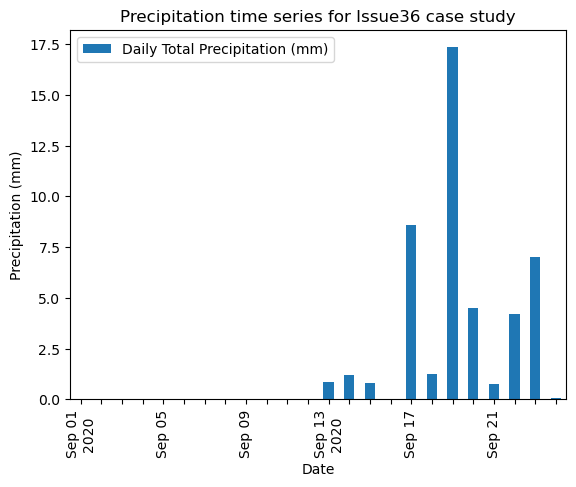

In [34]:
import matplotlib.ticker as ticker

precipitation_df = pd.read_csv(glob.glob(os.path.join(app.projectfolder,'ERA5/*.csv'))[0])
precipitation_df['Datetime'] = pd.to_datetime(precipitation_df['Datetime'])
precipitation_df.index = pd.to_datetime(precipitation_df['Datetime'])

# calculating Daily Total Precipitation
precipitation_df = precipitation_df.groupby(pd.Grouper(key='Datetime', axis=0,freq='D')).sum()
precipitation_df.rename(columns={"ERA5_tp_mm": "Daily Total Precipitation (mm)"}, inplace=True)

#plotting
ax = precipitation_df.plot(kind='bar', title='Precipitation time series for {} case study'.format(Projectname))
ax.axvline(pd.to_datetime(Flood_datetime), color="black", linestyle="dashed", lw=2)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(precipitation_df.index)
# Every 4th ticklable shows the month and day
ticklabels[::4] = [item.strftime('%b %d') for item in precipitation_df.index[::4]]
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in precipitation_df.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
# Add x-y axis labels
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (mm)")

plt.show()

### <a id='search_download'></a>3.5 Downloading Sentinel-1 backscatter observations


In [35]:
# Downloading Sentinel-1 dataset
app.run_download_S1_data('Download_S1_data')
# Downloading in the terminal works fine
# I have to fix the downloading from jupyter.

Found 14 products



 At your AOI, 0 (zero) Sentinel-1 images have been acquired
from your specified [Flood_datetime] till [Flood_datetime] + [after_flood_days]

Consider to change your [Flood_datetime] or [after_flood_days] configuration parameters

S1B_IW_GRDH_1SDV_20200919T182710_20200919T182735_023448_02C8A5_8377.SAFE acquisition 
 was acquired after -32.55 hours from the user-defined datetime of flood event 2020-09-21 03:00:00
This is download try # 1.
 We will try to download the requested products in 01 minutes.


100%|██████████| 4/4 [00:20<00:00,  5.21s/it]

Sentinel-1 data and orbit information have been successfully downloaded


0

### <a id='search_download'></a> 3.6 Preprocessing of multitemporal Sentinel-1 data

Preprocessing of Sentinel-1 SAR acquisitions consists of the following steps:
- Orbit correction
- Coregistration
- Subsetting
- Radiometric Calibration
- Geocoding

In [36]:
app.run_preprocessing_S1_data('Preprocessing_S1_data')

 We coregister the images in respect with the acquisition of S1B_IW_GRDH_1SDV_20200919T182710_20200919T182735_023448_02C8A5_8377.zip
Processing of flood image 20200919T182710
Processing of baseline image 20200901T182757
Processing of baseline image 20200907T182710
Processing of baseline image 20200913T182757
Refine borders of Sentinel-1 acquisitions
20200901T182757
20200907T182710
20200913T182757
Dropped... 20200913T182757
Baseline Stack images:
20200901T182757
20200907T182710
20200913T182757
Flood image:
20200919T182710
All information from SAR imagery are stored at /home/kleanthis/Projects/Issue36/Preprocessed/Stack/SAR_Stack.h5


0

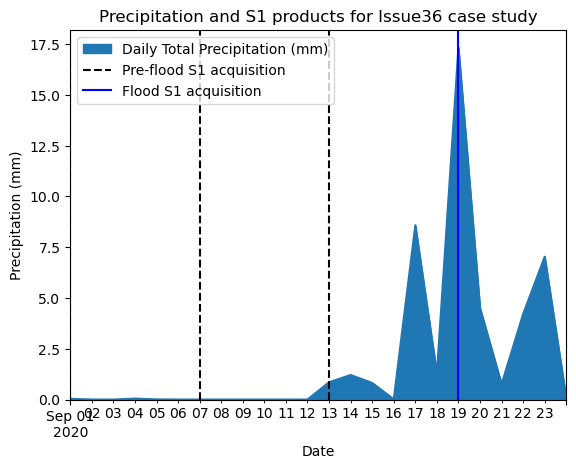

In [37]:
# plot a time figure that Sentinel-1 acquisitions (post-flood and pre-flood are visualized)
#plotting
ax = precipitation_df.plot(kind='area',
                           title='Precipitation and S1 products for {} case study'.format(Projectname))    
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(precipitation_df.index)
# Every 4th ticklable shows the month and day
ticklabels[::4] = [item.strftime('%b %d') for item in precipitation_df.index[::4]]
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in precipitation_df.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
# Add x-y axis labels
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (mm)")

S1_dir = os.path.join(projectfolder,'Sentinel_1_imagery')
flood_S1_image_filename = pd.read_csv(os.path.join(S1_dir,'flood_S1_filename.csv'))
S1_images = pd.read_csv(os.path.join(S1_dir,'baseline_images.csv'))
S1_images.index = pd.to_datetime(S1_images['Datetime'])

handles, label1  = ax.get_legend_handles_labels()

for index, S1_image in S1_images.iterrows():
    if S1_image['baseline']:
        pre_flood_line = ax.axvline(x=pd.to_datetime(S1_image['Datetime']), color='black', linestyle='--', label = 'Pre-flood S1 product')
    else:
        flood_line = ax.axvline(x=pd.to_datetime(S1_image['Datetime']), color='blue', linestyle='-', label = 'Flood S1 product')
        
handles.append(pre_flood_line)
handles.append(flood_line)
labels = [label1[0], "Pre-flood S1 acquisition", "Flood S1 acquisition"]
plt.legend(handles = handles[:], labels = labels)

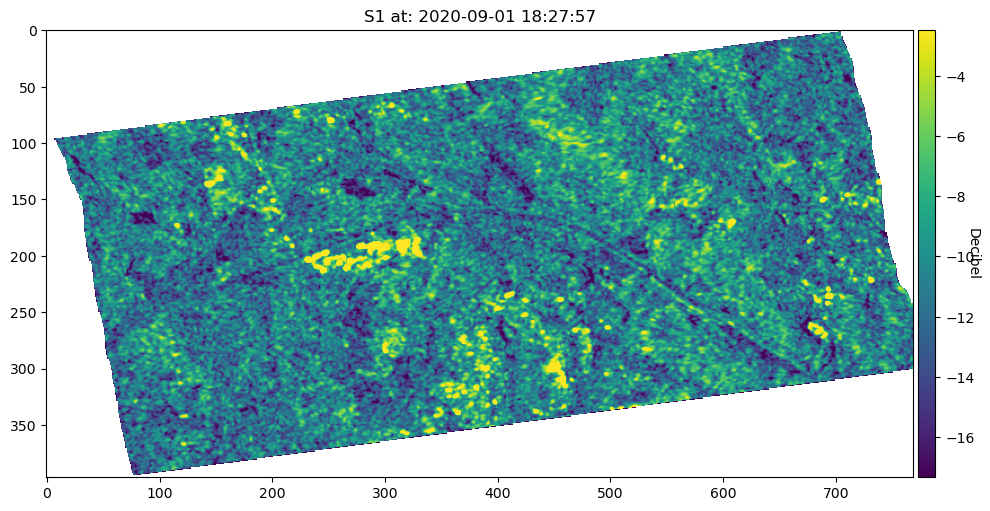

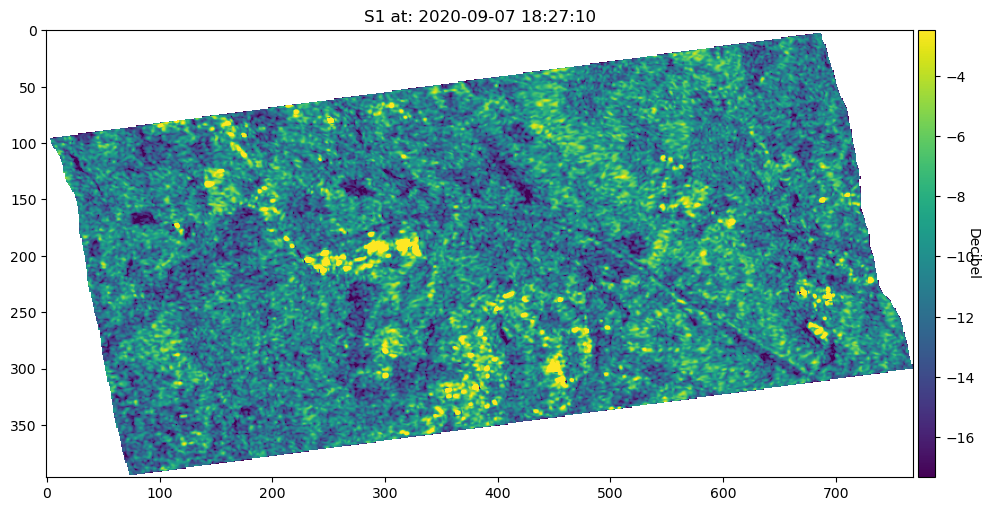

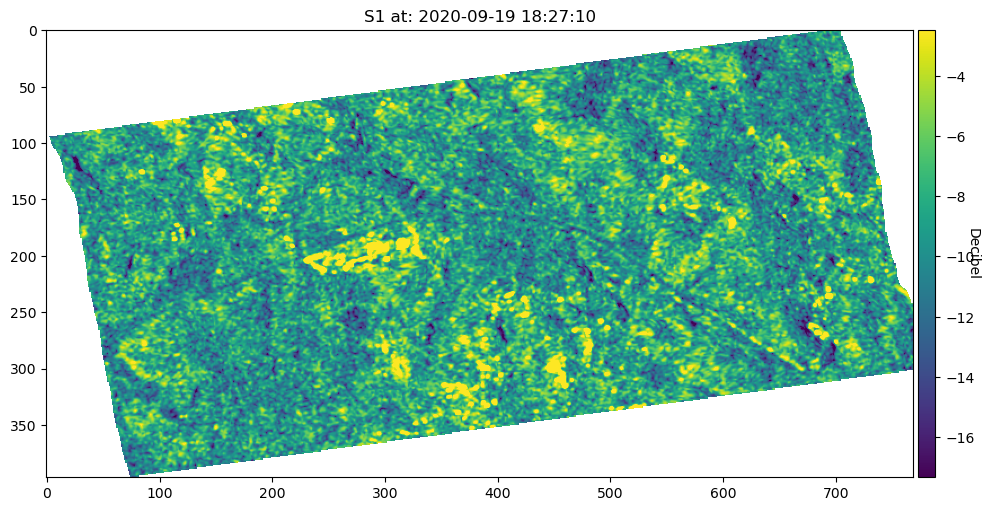

In [39]:
Preprocessing_dir = os.path.join(projectfolder, 'Preprocessed')
SAR_stack_file=os.path.join(Preprocessing_dir,'Stack/SAR_Stack.h5')
plot_stack=h5py.File(SAR_stack_file,'r')
number_of_images=plot_stack['Datetime_SAR'].shape[0]
# plot the backscatter information of all the  pre flood Sentinel-1 acquisitions
layers=['VV_db','VH-db','VV_VH_db']
for band_index, image in enumerate(range(number_of_images)):
            if band_index==0:
                vmin=np.nanquantile(plot_stack[layers[0]][band_index,...].flatten(), 0.01)
                vmax=np.nanquantile(plot_stack[layers[0]][band_index,...].flatten(), 0.99)

   
            plt.figure(figsize = (10,10))
            ax = plt.gca()
            im = ax.imshow(plot_stack[layers[0]][band_index,...],
                           vmin=vmin,
                           vmax=vmax)
            # add title
            S1_acquisition_time = pd.to_datetime(plot_stack['Datetime_SAR'][band_index].decode("utf-8"))
            plt.title("S1 at: {}".format(S1_acquisition_time))
            
            # add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="2%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            cbar.set_label('{}'.format('Decibel'), rotation=270)
            plt.tight_layout()

### <a id='search_download'></a> 3.7 Temporal Change Detection Analysis using Sentinel-1 backscattering values

Generation of t-score statistic map based on pre-flood and post-flood SAR observations.
$$t_{score}=\frac{\sigma_{flood}-mean(\sigma_{pre-flood})}{\frac{std(\sigma_{pre-flood})}{\sqrt(n)}}\$$

In [40]:
app.run_multitemporal_statistics('Statistical_analysis')


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00933958===================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.010673======================= ] (99% - 0.0s - 1 threads)


['20200901T182757', '20200907T182710', '20200919T182710']
T-score changes due to flood can be found at /home/kleanthis/Projects/Issue36/Results/t_scores_VV_VH_db.tif


0

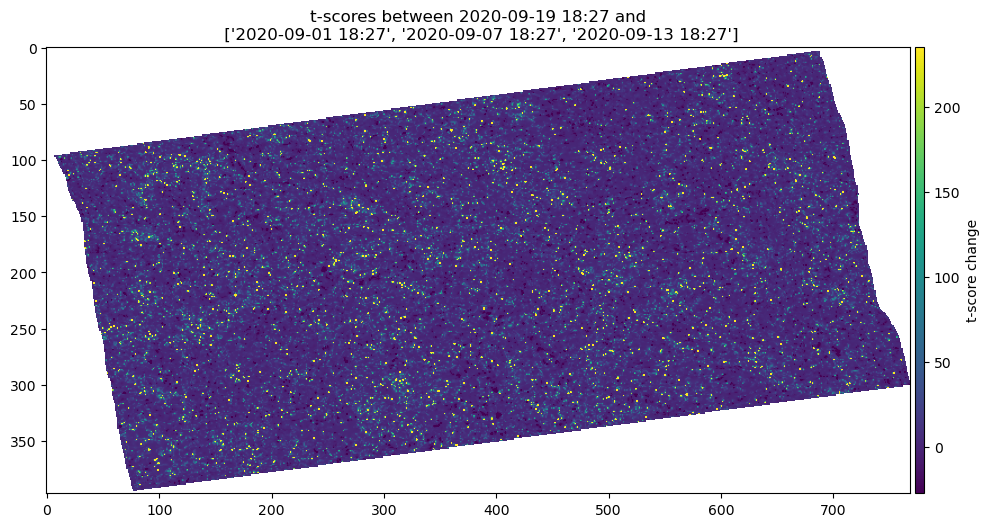

In [45]:
# plot the t-score maps (changes of backscatter information) pre-flood and post-flood
t_score_filename = glob.glob(os.path.join(app.Results_dir,'t_scores*.tif'))[0]
t_score_image = gdal.Open(t_score_filename).ReadAsArray()
vmin=np.nanquantile(t_score_image.flatten(), 0.01)
vmax=np.nanquantile(t_score_image.flatten(), 0.99)
plt.figure(figsize = (10,8))
ax = plt.gca()
im = ax.imshow(t_score_image,
               vmin=vmin,
               vmax=vmax)

# add title
flood_S1_image_filename = os.path.join(app.S1_dir,'flood_S1_filename.csv')
S1_acquisition_datetime = pd.read_csv(flood_S1_image_filename, index_col=0)
S1_flood_datetime = pd.to_datetime(S1_acquisition_datetime.loc['beginposition'].values[0])
S1_flood_str = S1_flood_datetime.strftime('%Y-%m-%d %H:%M')

pre_flood = os.path.join(app.S1_dir,'baseline_images.csv')
pre_flood_images = pd.read_csv(pre_flood)
S1_preflood_datetimes = pre_flood_images['Datetime'][pre_flood_images['baseline']==True].values
S1_preflood_datetimes = [pd.to_datetime(pre_flood_datetime).strftime('%Y-%m-%d %H:%M') for pre_flood_datetime in S1_preflood_datetimes]

plt.title("t-scores between {} and\n {}".format(S1_flood_str, S1_preflood_datetimes))

# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('{}'.format('t-score change'), rotation=90)
plt.tight_layout()

### <a id='search_download'></a> 3.8 Identification of Flooded Regions based on adaptive Otsu thresholding 

The identification (mapping) of the flooded regions is based on the following steps:
- Selection of regions that have experience large and small backscatter changes (based on t-score image). The selection is perform by calculating bimodality coefficient index.
$$BC = \frac{s^2+1}{k+3\frac{(n-1)^2}{(n-2)(n-3)}}$$
where $ s $ is the skewness, $ k $ is the kurtosis and $ n $ the number of samples (pixels)
If the bimodality coefficient is above 0.555, multimodality is expected (Freeman et al., 2013) and the region is selected.

- A single threshold for the AOI using the Otsu algorithm (Otsu et al., 1979) is calculated and applied in order to discriminate the flooded and the non-flooded regions. 

- Discard high slope regions (>12 degrees) in order to mitigate commision errors.

- Local adaptive thresholding

- Region growing

- Morphological filtering (remove_small_holes, diameter_opening, remove_small_objects) based on given minimum mapping unit.

Freeman, J.B.; Dale, R. Assessing bimodality to detect the presence of a dual cognitive process. Behav. Res. Methods 2013, 45, 83–97.  
Otsu, N. A threshold selection method from gray-level histograms. IEEE Trans. Syst. Man. Cybern. 1979, 9, 62–66.

In [46]:
app.run_get_flood_map('Floodwater_classification')

Calculating Bi/multi modality mask...
Calculating global flood mask using global threshold...
Discard high slope regions ...
Performing local adaptive thresholding ...
Running Region Growing operation...
Running Morphological filtering operation...
Saving final flood map to disk ...
Floodwater map can be found at /home/kleanthis/Projects/Issue36/Results/Flood_map_Issue36.tif


0

Selecting only regions that present Multi/bi modality let use select a better 
threshold.

Text(0.5, 1.0, 'Bi/Multi modality mask over t-scores.')

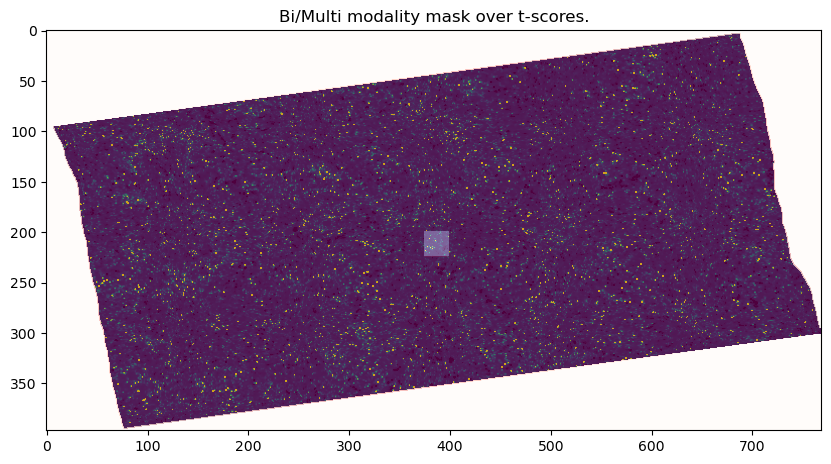

In [48]:
t_score_filename = glob.glob(os.path.join(app.Results_dir,'t_scores*.tif'))[0]
t_score_image = gdal.Open(t_score_filename).ReadAsArray()
vmin=np.nanquantile(t_score_image.flatten(), 0.01)
vmax=np.nanquantile(t_score_image.flatten(), 0.99)
plt.figure(figsize = (10,8))
ax = plt.gca()
im = ax.imshow(t_score_image,
               vmin=vmin,
               vmax=vmax)
ax.imshow(app.multimodality_mask>0, alpha=0.3, cmap = 'Reds')
plt.title("Bi/Multi modality mask over t-scores.")


Histogram Thresholding

Text(54.58247756958008, 0, 'Global Otsu threshold')

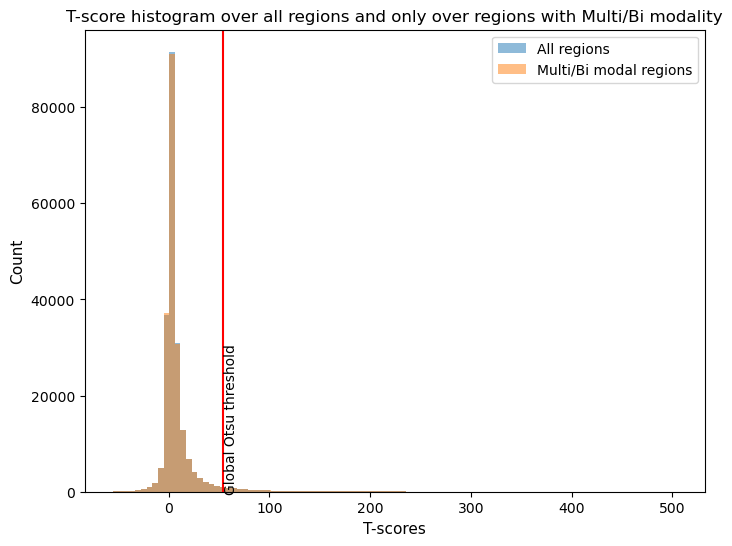

In [49]:
t_score_values = t_score_image.flatten()
vmin = np.nanquantile(t_score_values, 0.005)
vmax = np.nanquantile(t_score_values, 0.995)
t_score_values[t_score_values>vmax]=np.nan
t_score_values[t_score_values<vmin]=np.nan
t_score_values = t_score_values[~np.isnan(t_score_values)]

t_score_values_BC = t_score_image[app.multimodality_mask].flatten()
vmin_BC = np.nanquantile(t_score_values_BC, 0.005)
vmax_BC = np.nanquantile(t_score_values_BC, 0.995)
t_score_values_BC[t_score_values_BC>vmax_BC]=np.nan
t_score_values_BC[t_score_values_BC<vmin_BC]=np.nan
t_score_values_BC = t_score_values_BC[~np.isnan(t_score_values_BC)]

plt.figure(figsize=(8,6))
plt.hist(t_score_values, bins=100, alpha=0.5, label="All regions")
plt.hist(t_score_values_BC, bins=100, alpha=0.5, label="Multi/Bi modal regions")
plt.title("T-score histogram over all regions and only over regions with Multi/Bi modality")
plt.xlabel("T-scores", size=11)
plt.ylabel("Count", size=11)
plt.legend(loc='upper right')

plt.axvline(app.glob_thresh, color='r', label='axvline - full height')
plt.text(app.glob_thresh+0.5,0,'Global Otsu threshold',rotation=90)

Download Land cover information from ESA worldcover 2021

In [50]:
app.run_download_landcover('Download_worldcover_LC')

100%|██████████| 1/1 [00:35<00:00, 35.40s/it]


Todo: Add t-score image, Add label that denotes the date of the flood map, Add area of Interest


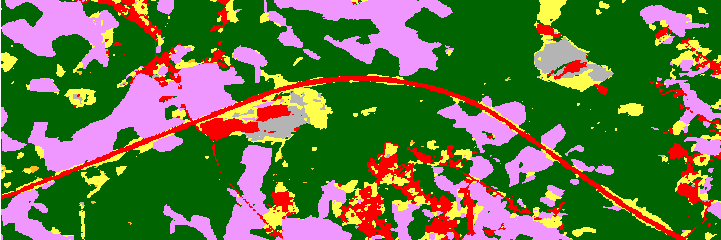
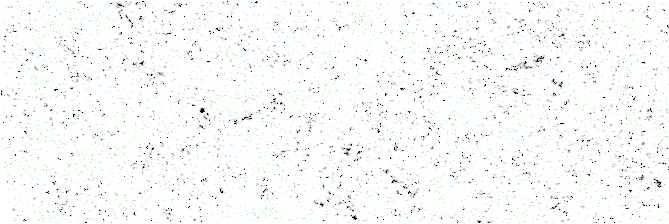
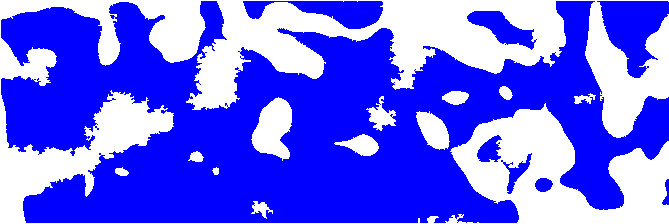

In [51]:
import matplotlib
import branca.colormap as cm
from folium.plugins import MeasureControl, Draw

# Read AOI
aoi = gpd.read_file(app.geojson_S1)

# AOI bounds
left, bottom, right, top = aoi.total_bounds

# Define map bounds
map_bounds = [[bottom, left], [top, right]]

# Read flood binary mask using AOI
flood_fpath = os.path.join(app.Results_dir, 'Flood_map_{}.tif'.format(app.projectname))
with rio.open(flood_fpath) as src:
    flood, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True)
    flood = flood[0,:,:]

#could implement CARTO basemaps (free api will be needed)
# Create a map located to the AOI
m = folium.Map(location=[aoi.centroid.y[0], aoi.centroid.x[0]], tiles="Stamen Terrain", zoom_start=13)

folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)

# m = folium.Map(
#     tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr = 'Esri',
#     location=[aoi.centroid.y[0], aoi.centroid.x[0]],
#     zoom_start=13).add_child(MeasureControl())

# measuring funcs
MeasureControl('bottomleft').add_to(m)

# drawing funcs
draw = Draw(export = True,
            filename=os.path.join(projectfolder,'myJson.json'),
            position='topleft').add_to(m)

# ESA worldcover 
with rio.open(app.LC_worldcover) as src:
    LC_cover, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True)
    LC_cover = LC_cover[0,:,:]


m.add_child(folium.raster_layers.ImageOverlay(LC_cover,
            name='ESA Worldcover 2021',
            opacity=1,
            bounds=map_bounds,
            colormap = lambda x: app.LC_worldcover_colors[x]))

# Read t-score image using AOI
t_scores_fpath = os.path.join(app.Results_dir, 't_scores_VV_VH_db.tif')
with rio.open(t_scores_fpath) as src:
    t_scores, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True)
    t_scores = t_scores[0,:,:]  

vmin = np.nanquantile(t_scores.flatten(), 0.005)
vmax = np.nanquantile(t_scores.flatten(), 0.995)
t_scores = np.clip(t_scores, vmin, vmax)

cmap = cm.LinearColormap(['black', 'white', 'lightgreen'],
                               index=[vmin, 0, vmax],
                               vmin=vmin, vmax=vmax)

cmap.caption = 'T-scores (changes)'
cmap_func = lambda x: matplotlib.colors.to_rgba(cmap(x)) if ~np.isnan(x) else (0,0,0,0)
folium.raster_layers.ImageOverlay(t_scores,
                                  name='T-scores (changes)',
                                  opacity=1,
                                  bounds=map_bounds,
                                  colormap=cmap_func).add_to(m)
m.add_child(cmap)

# Add flood image to the map, flood background is transparent
raster_to_coloridx = {1: (0.0, 0.0, 1.0, 1.0),
                      0: (0.0, 0.0, 0.0, 0.0)}

m.add_child(folium.raster_layers.ImageOverlay(flood, 
                                             name='Flooded Estimations {} (UTC)'.format(S1_flood_str),
                                             opacity=0.2,
                                             bounds=map_bounds,
                                             colormap=lambda x: raster_to_coloridx[x]))

folium.GeoJson(aoi["geometry"], name='Area of Interest').add_to(m)
#folium.Popup('Area of Interest').add_to(m)
folium.LayerControl('bottomright', collapsed=False).add_to(m)

m

<div class="alert alert-block alert-warning">

<font size="3"> In order to visualize the interactive map please copy and paste the url of the notebook at [nbviewer](https://nbviewer.org/)
</font>
</div>

<div class="alert alert-block alert-warning">

### Feedback:
<font size="3"> Feel free to contact us if you have any questions. 
Contact email : floodmappingteam@gmail.com
</font>

<div>